In [2]:
pip install networkx matplotlib numpy


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import community

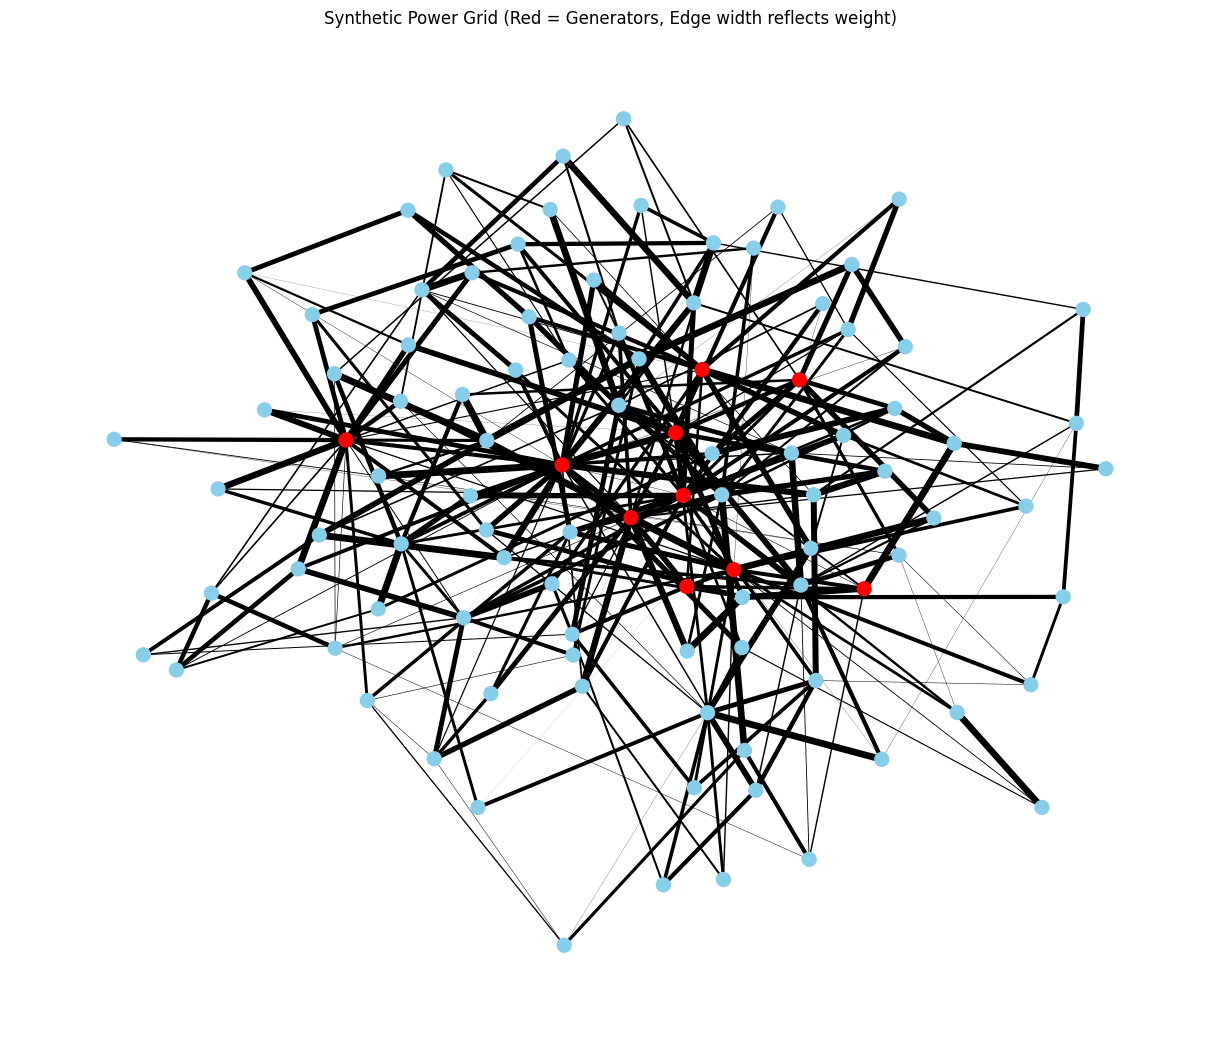

In [3]:
# Create a synthetic grid graph
G = nx.powerlaw_cluster_graph(100, 3, 0.05) # 100 nodes, ~300 edges

# Add random weights to edges to simulate impedance or capacity
for u, v in G.edges():
    G.edges[u,v]['weight'] = np.random.rand() * 10

# Label 10% as power generators
for i, node in enumerate(G.nodes()):
 G.nodes[node]['type'] = 'generator' if i < 10 else 'substation'
# Visualize
weights = [G.edges[u, v]['weight'] / 2 for u, v in G.edges()]
color_map = ['red' if G.nodes[n]['type'] == 'generator' else 'skyblue' for n in G.nodes()]
plt.figure(figsize=(12, 10))
nx.draw(G, node_color=color_map, with_labels=False, node_size=100, width=weights)
plt.title("Synthetic Power Grid (Red = Generators, Edge width reflects weight)")
plt.show()

In [4]:
# Compute betweenness centrality, considering edge weights
centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)
top_5 = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Critical Nodes (by Weighted Betweenness Centrality):")
for node, score in top_5:
  print(f"Node {node} - Centrality: {score:.4f}")

Top 5 Critical Nodes (by Weighted Betweenness Centrality):
Node 4 - Centrality: 0.5116
Node 6 - Centrality: 0.4319
Node 0 - Centrality: 0.2606
Node 2 - Centrality: 0.1682
Node 62 - Centrality: 0.1544


In [5]:
# Remove most central node
G_removed = G.copy()
G_removed.remove_node(top_5[0][0])
# Check if network is still connected
is_connected = nx.is_connected(G_removed)
print(f"Grid remains connected after removal? {is_connected}")
# Size of largest connected component
largest_cc = len(max(nx.connected_components(G_removed), key=len))
print(f"Largest component size after failure: {largest_cc} / {G.number_of_nodes()}")

Grid remains connected after removal? True
Largest component size after failure: 99 / 100


Detected 8 communities


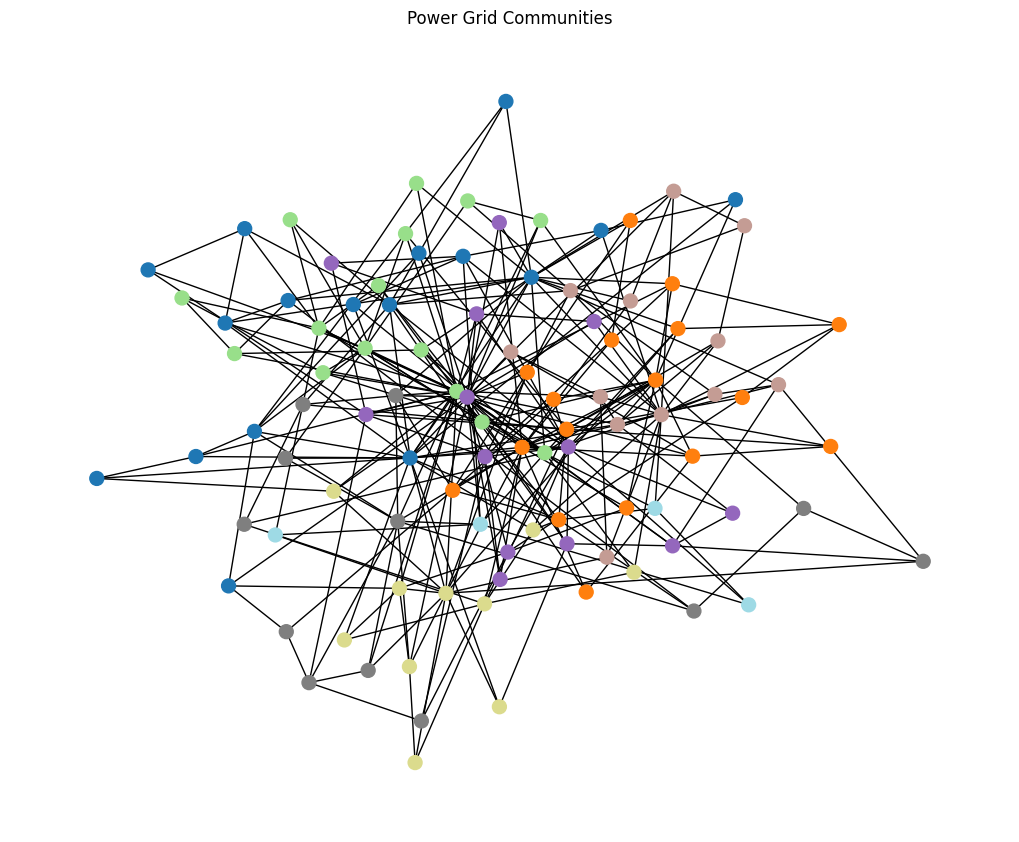

In [6]:
# Use greedy modularity communities
communities = list(community.greedy_modularity_communities(G))
print(f"Detected {len(communities)} communities")
# Assign each node a community index
node_color_map = {}
for i, com in enumerate(communities):
 for node in com:
  node_color_map[node] = i
colors = [node_color_map[n] for n in G.nodes()]
plt.figure(figsize=(10, 8))
nx.draw(G, node_color=colors, with_labels=False, node_size=100, cmap=plt.cm.tab20)
plt.title("Power Grid Communities")
plt.show()

In [7]:
nx.write_graphml(G, "synthetic_power_grid.graphml")

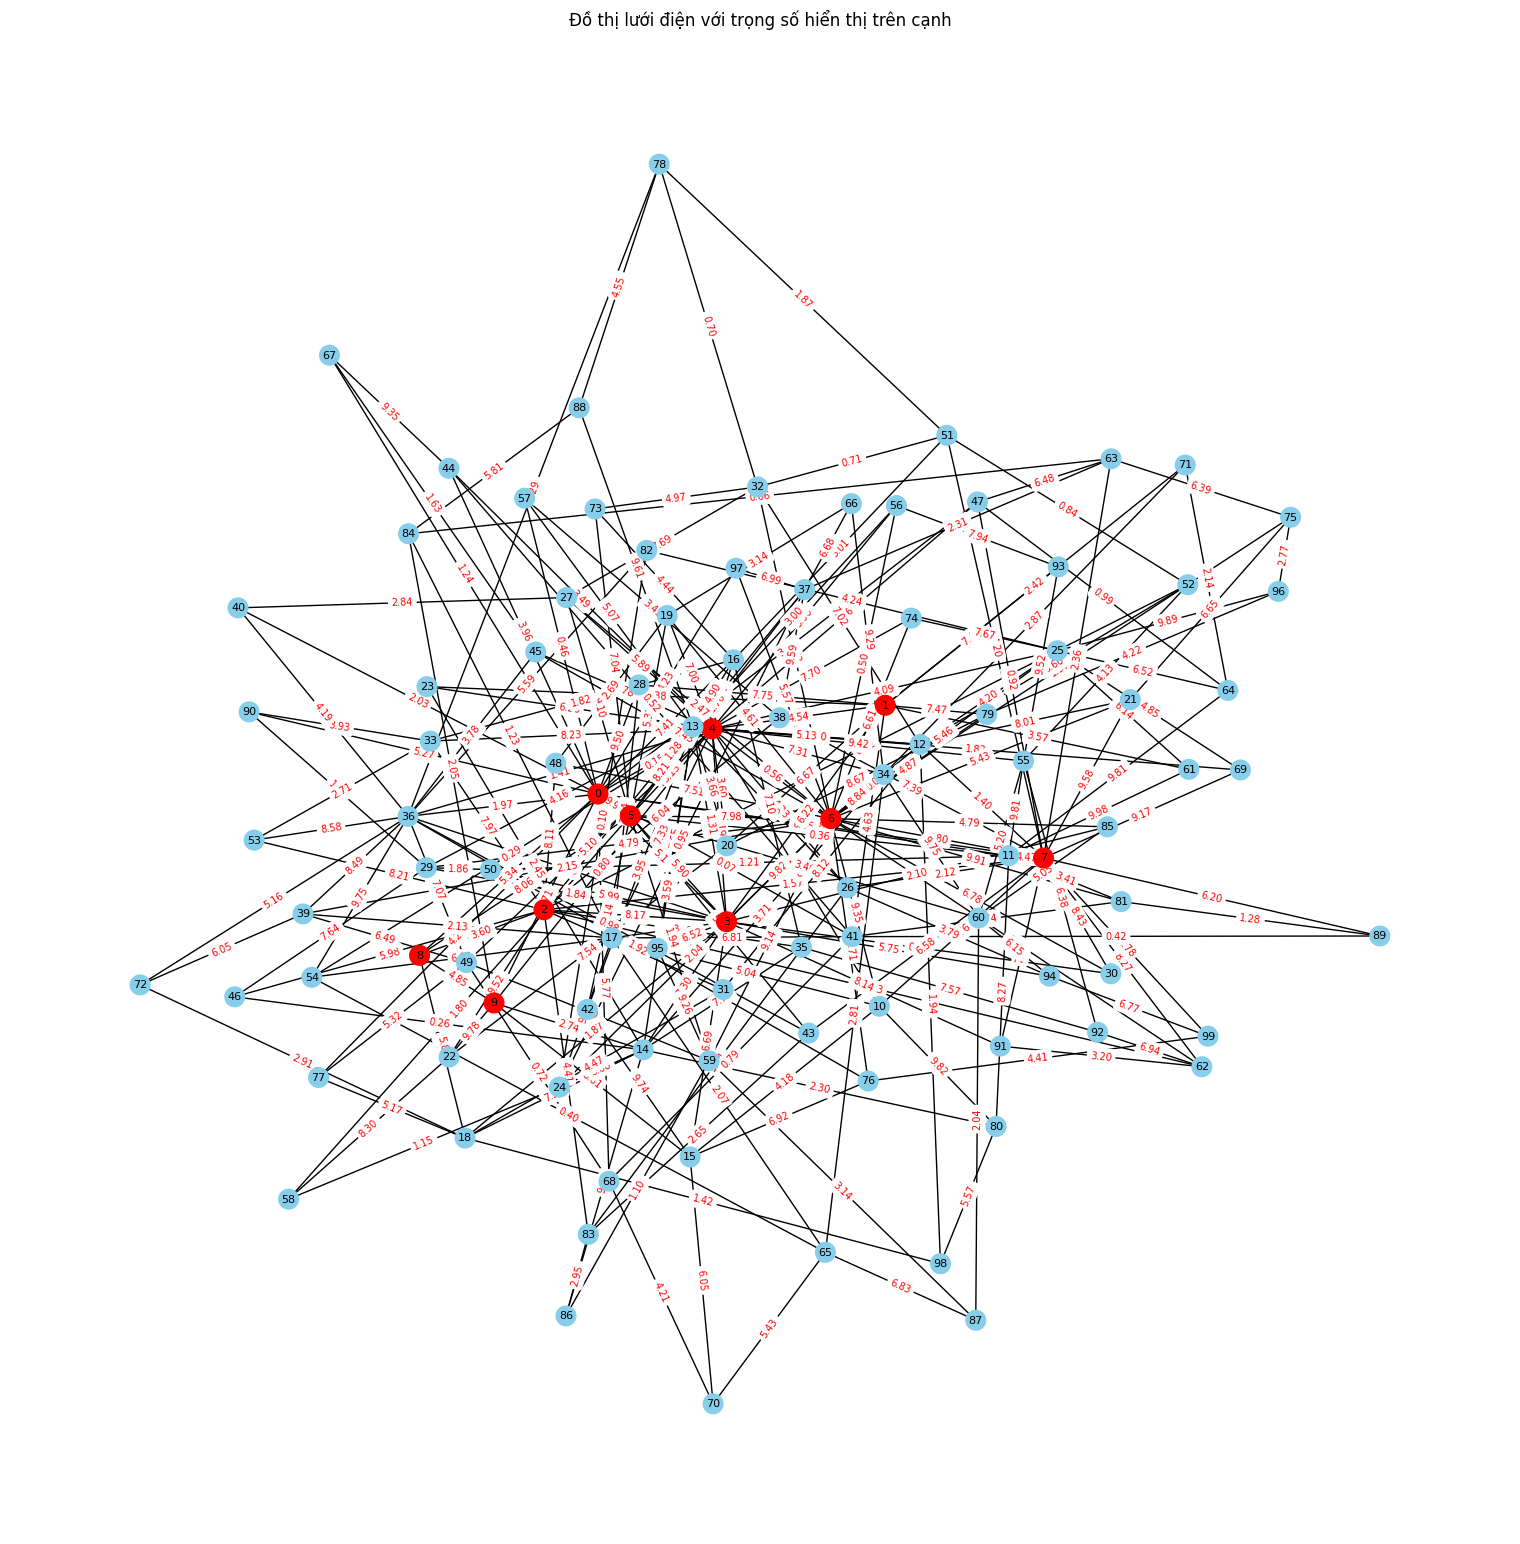

In [9]:
# Vẽ lại đồ thị và hiển thị trọng số trên các cạnh
plt.figure(figsize=(15, 15))

# Sử dụng spring_layout để có vị trí các nút ổn định
pos = nx.spring_layout(G, seed=42)

# Vẽ các nút và màu sắc như cũ
nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=200, font_size=8)

# Tạo nhãn cho các cạnh từ thuộc tính 'weight'
edge_labels = nx.get_edge_attributes(G, 'weight')
# Làm tròn giá trị để hiển thị gọn hơn
for edge, weight in edge_labels.items():
    edge_labels[edge] = f'{weight:.2f}'

# Vẽ nhãn của các cạnh
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=7)

plt.title("Đồ thị lưới điện với trọng số hiển thị trên cạnh")
plt.show()


### Bài tập: So sánh độ bền vững giữa cấu trúc lưới dạng scale-free và ngẫu nhiên

Để so sánh, chúng ta sẽ:
1. Tạo một đồ thị ngẫu nhiên (Erdős-Rényi) có cùng số nút và số cạnh với đồ thị scale-free đã tạo trước đó.
2. Mô phỏng hai loại tấn công trên cả hai đồ thị:
    - **Tấn công ngẫu nhiên:** Loại bỏ các nút một cách ngẫu nhiên.
    - **Tấn công có chủ đích:** Loại bỏ các nút theo thứ tự bậc (degree) từ cao đến thấp.
3. Đo lường sự thay đổi kích thước của thành phần liên thông lớn nhất (Largest Connected Component - LCC) sau mỗi lần loại bỏ một nút.
4. Vẽ biểu đồ so sánh để xem cấu trúc nào bền vững hơn với từng loại tấn công.

In [10]:
# 1. Tạo đồ thị ngẫu nhiên (Erdos-Renyi)
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
p = 2 * n_edges / (n_nodes * (n_nodes - 1)) # Xác suất để có cùng số cạnh

G_random = nx.erdos_renyi_graph(n_nodes, p, seed=42)

print(f"Đồ thị Scale-Free: {G.number_of_nodes()} nút, {G.number_of_edges()} cạnh")
print(f"Đồ thị Ngẫu nhiên: {G_random.number_of_nodes()} nút, {G_random.number_of_edges()} cạnh")


# 2. Hàm mô phỏng tấn công và đo lường độ bền vững
def simulate_attack(graph, attack_type='random'):
    g = graph.copy()
    lcc_sizes = [len(max(nx.connected_components(g), key=len))]
    
    if attack_type == 'random':
        nodes_to_remove = list(g.nodes())
        np.random.shuffle(nodes_to_remove)
    elif attack_type == 'targeted':
        nodes_to_remove = sorted(g.degree, key=lambda x: x[1], reverse=True)
        nodes_to_remove = [node for node, degree in nodes_to_remove]
        
    for node in nodes_to_remove[:-1]: # Để lại ít nhất 1 nút
        g.remove_node(node)
        if nx.is_connected(g):
            largest_cc = len(max(nx.connected_components(g), key=len))
        elif len(g) > 0:
            largest_cc = len(max(nx.connected_components(g), key=len))
        else:
            largest_cc = 0
        lcc_sizes.append(largest_cc)
        
    return [size / graph.number_of_nodes() for size in lcc_sizes]


Đồ thị Scale-Free: 100 nút, 291 cạnh
Đồ thị Ngẫu nhiên: 100 nút, 265 cạnh


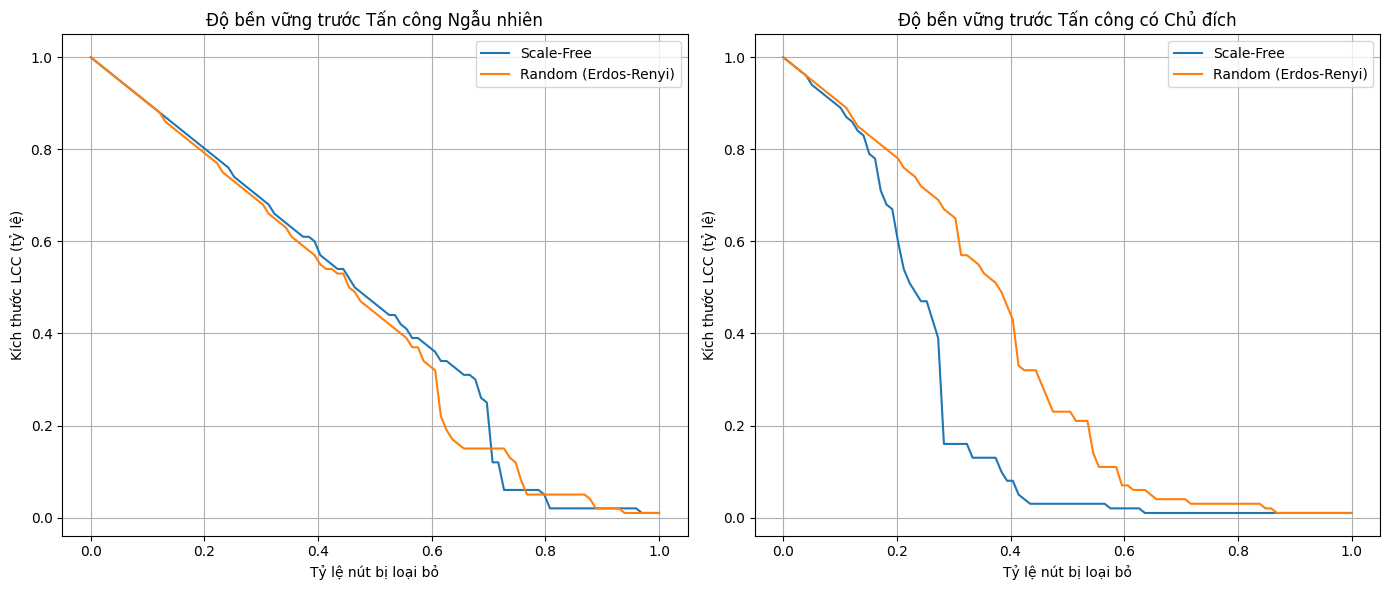

In [11]:
# 3. Thực hiện mô phỏng
# Tấn công ngẫu nhiên
sf_random_attack = simulate_attack(G, 'random')
er_random_attack = simulate_attack(G_random, 'random')

# Tấn công có chủ đích
sf_targeted_attack = simulate_attack(G, 'targeted')
er_targeted_attack = simulate_attack(G_random, 'targeted')

# 4. Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 6))

# Biểu đồ cho tấn công ngẫu nhiên
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, 1, len(sf_random_attack)), sf_random_attack, label='Scale-Free')
plt.plot(np.linspace(0, 1, len(er_random_attack)), er_random_attack, label='Random (Erdos-Renyi)')
plt.xlabel("Tỷ lệ nút bị loại bỏ")
plt.ylabel("Kích thước LCC (tỷ lệ)")
plt.title("Độ bền vững trước Tấn công Ngẫu nhiên")
plt.grid(True)
plt.legend()

# Biểu đồ cho tấn công có chủ đích
plt.subplot(1, 2, 2)
plt.plot(np.linspace(0, 1, len(sf_targeted_attack)), sf_targeted_attack, label='Scale-Free')
plt.plot(np.linspace(0, 1, len(er_targeted_attack)), er_targeted_attack, label='Random (Erdos-Renyi)')
plt.xlabel("Tỷ lệ nút bị loại bỏ")
plt.ylabel("Kích thước LCC (tỷ lệ)")
plt.title("Độ bền vững trước Tấn công có Chủ đích")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Bài tập: Mô phỏng hiệu ứng thác đổ (Cascading Failures)

Trong bài tập này, chúng ta sẽ mô phỏng cách một sự cố ban đầu có thể lan truyền khắp mạng lưới điện.

**Mô hình mô phỏng:**
1.  **Tải ban đầu (Initial Load):** Chúng ta giả định tải ban đầu của mỗi nút tỷ lệ thuận với `betweenness centrality` của nó. Đây là một giả định hợp lý vì các nút có độ trung gian cao thường xử lý nhiều luồng "dòng chảy" trong mạng.
2.  **Công suất (Capacity):** Mỗi nút có một công suất tối đa, được định nghĩa là tải ban đầu của nó nhân với một hệ số `(1 + alpha)`, trong đó `alpha` là một tham số dung sai (tolerance parameter). Nếu `alpha = 0.1`, có nghĩa là mỗi nút có thể chịu được thêm 10% tải so với mức bình thường.
3.  **Sự cố ban đầu:** Chúng ta bắt đầu bằng cách làm hỏng nút có độ trung gian cao nhất.
4.  **Quá trình thác đổ:**
    - Khi một nút hỏng, toàn bộ tải của nó sẽ được phân phối lại đều cho các nút lân cận còn hoạt động.
    - Nếu bất kỳ nút lân cận nào nhận thêm tải và tổng tải mới của nó vượt quá công suất, nút đó cũng sẽ hỏng.
    - Quá trình này tiếp tục cho đến khi không còn nút nào bị hỏng trong một vòng lặp, và mạng đạt trạng thái ổn định.
5.  **Đánh giá thiệt hại:** Chúng ta sẽ đo lường tổng số nút bị hỏng và kích thước của mạng còn lại.

Sự cố ban đầu tại nút: 4 với tải 2482.00
  -> Các nút mới bị hỏng: {1, 3, 5, 9, 10, 12, 16, 17, 19, 20, 23, 25, 26, 27, 33, 34, 44, 45, 47, 49, 54, 56, 69, 74}
  -> Các nút mới bị hỏng: {71, 79, 61, 28, 93}
  -> Các nút mới bị hỏng: {36, 15, 18, 50, 85, 94, 91, 29, 30, 95}
  -> Các nút mới bị hỏng: {37, 8, 73, 42, 11, 43, 13, 58, 59, 60}
  -> Các nút mới bị hỏng: {0, 84, 14, 22}
  -> Các nút mới bị hỏng: {80, 7}
  -> Các nút mới bị hỏng: {32, 98, 52, 21, 31}
  -> Các nút mới bị hỏng: {51, 35}
  -> Các nút mới bị hỏng: {24, 39}
  -> Các nút mới bị hỏng: {48, 66}
  -> Các nút mới bị hỏng: {64, 82, 96}
  -> Các nút mới bị hỏng: {83}
  -> Các nút mới bị hỏng: {40, 6}
  -> Các nút mới bị hỏng: {90, 53}
  -> Các nút mới bị hỏng: {65}
  -> Các nút mới bị hỏng: {41, 67}
  -> Các nút mới bị hỏng: {63}
  -> Các nút mới bị hỏng: {68, 77}
  -> Các nút mới bị hỏng: {55}
  -> Các nút mới bị hỏng: {72, 76, 78}
  -> Các nút mới bị hỏng: {70}
  -> Các nút mới bị hỏng: {99}
  -> Các nút mới bị hỏng: {46

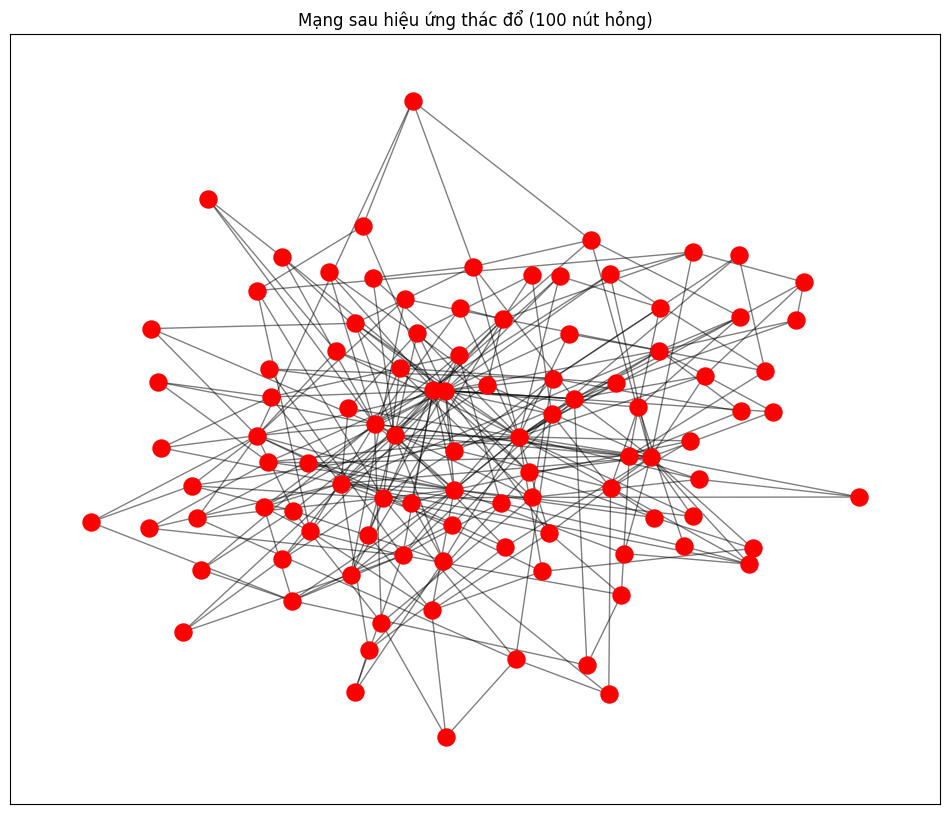

In [12]:
def simulate_cascading_failure(graph, alpha=0.2):
    """
    Mô phỏng hiệu ứng thác đổ trong một mạng.
    
    Args:
        graph (nx.Graph): Đồ thị mạng.
        alpha (float): Hệ số dung sai công suất.
    
    Returns:
        int: Tổng số nút đã hỏng.
        set: Tập hợp các nút đã hỏng.
    """
    # 1. Tính toán tải và công suất ban đầu
    # Sử dụng betweenness centrality làm thước đo tải
    loads = nx.betweenness_centrality(graph, weight='weight', normalized=False)
    capacities = {node: load * (1 + alpha) for node, load in loads.items()}
    
    # Tạo một bản sao của đồ thị để mô phỏng
    g_sim = graph.copy()
    
    # 2. Bắt đầu sự cố bằng cách loại bỏ nút có tải cao nhất
    initial_failure_node = max(loads, key=loads.get)
    
    failed_nodes = {initial_failure_node}
    nodes_to_process = [initial_failure_node] # Các nút vừa bị hỏng cần xử lý
    
    print(f"Sự cố ban đầu tại nút: {initial_failure_node} với tải {loads[initial_failure_node]:.2f}")

    # 3. Vòng lặp mô phỏng thác đổ
    while nodes_to_process:
        newly_failed_in_iteration = set()
        
        # Lấy một nút từ danh sách cần xử lý
        node_failing = nodes_to_process.pop(0)
        
        # Lấy các nút lân cận còn hoạt động
        neighbors = [n for n in g_sim.neighbors(node_failing) if n not in failed_nodes]
        if not neighbors:
            continue # Không có hàng xóm nào để phân phối lại tải

        # Phân phối lại tải của nút hỏng cho các hàng xóm
        load_to_redistribute = loads[node_failing] / len(neighbors)
        
        for neighbor in neighbors:
            loads[neighbor] += load_to_redistribute
            
            # Kiểm tra xem nút lân cận có bị quá tải không
            if loads[neighbor] > capacities[neighbor] and neighbor not in failed_nodes:
                newly_failed_in_iteration.add(neighbor)

        # Thêm các nút vừa hỏng vào danh sách chính và danh sách cần xử lý
        if newly_failed_in_iteration:
            failed_nodes.update(newly_failed_in_iteration)
            nodes_to_process.extend(list(newly_failed_in_iteration))
            print(f"  -> Các nút mới bị hỏng: {newly_failed_in_iteration}")

    return len(failed_nodes), failed_nodes


# Chạy mô phỏng với alpha = 0.2 (20% công suất dự phòng)
total_failures, failed_set = simulate_cascading_failure(G, alpha=0.2)

print(f"\nKết quả mô phỏng thác đổ:")
print(f"Tổng số nút bị hỏng: {total_failures} / {G.number_of_nodes()}")
print(f"Tỷ lệ mạng bị sập: {total_failures / G.number_of_nodes():.2%}")

# Trực quan hóa kết quả
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
# Vẽ các nút bình thường
nx.draw_networkx_nodes(G, pos, nodelist=set(G.nodes()) - failed_set, node_color='skyblue', node_size=100)
# Vẽ các nút bị hỏng
nx.draw_networkx_nodes(G, pos, nodelist=failed_set, node_color='red', node_size=150)
# Vẽ các cạnh
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title(f"Mạng sau hiệu ứng thác đổ ({total_failures} nút hỏng)")
plt.show()


### Bài tập: Tính toán độ dài đường đi trung bình trước và sau tấn công

Một thước đo quan trọng khác về hiệu quả và độ bền vững của mạng là **độ dài đường đi trung bình (average path length)**. Nó cho biết khoảng cách trung bình giữa hai nút bất kỳ trong mạng.

-   **Trước tấn công:** Chúng ta sẽ tính giá trị này cho cả hai đồ thị ban đầu (scale-free và ngẫu nhiên).
-   **Sau tấn công:** Chúng ta sẽ tính lại giá trị này sau khi loại bỏ một nút duy nhất theo hai kịch bản:
    1.  **Tấn công ngẫu nhiên:** Loại bỏ một nút được chọn ngẫu nhiên.
    2.  **Tấn công có chủ đích:** Loại bỏ nút có bậc cao nhất.

Nếu việc loại bỏ nút làm cho đồ thị bị ngắt kết nối, chúng ta sẽ tính độ dài đường đi trung bình trên **thành phần liên thông lớn nhất (LCC)** còn lại.

In [13]:
def get_average_path_length(graph):
    """Tính độ dài đường đi trung bình trên thành phần liên thông lớn nhất."""
    if not nx.is_connected(graph):
        # Lấy thành phần liên thông lớn nhất
        largest_cc_nodes = max(nx.connected_components(graph), key=len)
        subgraph = graph.subgraph(largest_cc_nodes)
        return nx.average_shortest_path_length(subgraph)
    return nx.average_shortest_path_length(graph)

# --- 1. Trước tấn công ---
apl_sf_before = get_average_path_length(G)
apl_er_before = get_average_path_length(G_random)

print("--- Độ dài đường đi trung bình TRƯỚC tấn công ---")
print(f"Scale-Free: {apl_sf_before:.4f}")
print(f"Random (Erdos-Renyi): {apl_er_before:.4f}")
print("-" * 20)


# --- 2. Sau tấn công ngẫu nhiên ---
# Tạo bản sao để không ảnh hưởng đồ thị gốc
g_sf_rand_attack = G.copy()
g_er_rand_attack = G_random.copy()

# Chọn một nút ngẫu nhiên để loại bỏ
node_to_remove_rand_sf = np.random.choice(list(g_sf_rand_attack.nodes()))
node_to_remove_rand_er = np.random.choice(list(g_er_rand_attack.nodes()))

g_sf_rand_attack.remove_node(node_to_remove_rand_sf)
g_er_rand_attack.remove_node(node_to_remove_rand_er)

apl_sf_after_rand = get_average_path_length(g_sf_rand_attack)
apl_er_after_rand = get_average_path_length(g_er_rand_attack)

print("--- Sau TẤN CÔNG NGẪU NHIÊN (loại bỏ 1 nút) ---")
print(f"Scale-Free: {apl_sf_after_rand:.4f} (thay đổi: {apl_sf_after_rand - apl_sf_before:+.4f})")
print(f"Random (Erdos-Renyi): {apl_er_after_rand:.4f} (thay đổi: {apl_er_after_rand - apl_er_before:+.4f})")
print("-" * 20)


# --- 3. Sau tấn công có chủ đích ---
# Tạo bản sao
g_sf_targeted_attack = G.copy()
g_er_targeted_attack = G_random.copy()

# Tìm nút có bậc cao nhất để loại bỏ
node_to_remove_targeted_sf = sorted(g_sf_targeted_attack.degree, key=lambda x: x[1], reverse=True)[0][0]
node_to_remove_targeted_er = sorted(g_er_targeted_attack.degree, key=lambda x: x[1], reverse=True)[0][0]

g_sf_targeted_attack.remove_node(node_to_remove_targeted_sf)
g_er_targeted_attack.remove_node(node_to_remove_targeted_er)

apl_sf_after_targeted = get_average_path_length(g_sf_targeted_attack)
apl_er_after_targeted = get_average_path_length(g_er_targeted_attack)

print("--- Sau TẤN CÔNG CÓ CHỦ ĐÍCH (loại bỏ nút bậc cao nhất) ---")
print(f"Scale-Free: {apl_sf_after_targeted:.4f} (thay đổi: {apl_sf_after_targeted - apl_sf_before:+.4f})")
print(f"Random (Erdos-Renyi): {apl_er_after_targeted:.4f} (thay đổi: {apl_er_after_targeted - apl_er_before:+.4f})")
print("-" * 20)


--- Độ dài đường đi trung bình TRƯỚC tấn công ---
Scale-Free: 2.6107
Random (Erdos-Renyi): 2.9046
--------------------
--- Sau TẤN CÔNG NGẪU NHIÊN (loại bỏ 1 nút) ---
Scale-Free: 2.6205 (thay đổi: +0.0098)
Random (Erdos-Renyi): 2.9064 (thay đổi: +0.0018)
--------------------
--- Sau TẤN CÔNG CÓ CHỦ ĐÍCH (loại bỏ nút bậc cao nhất) ---
Scale-Free: 2.7295 (thay đổi: +0.1188)
Random (Erdos-Renyi): 2.9571 (thay đổi: +0.0525)
--------------------
